In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from lab_processing import print_errors, create_plot

In [2]:
plates = np.loadtxt('data/plates.tsv')
data1 = pd.read_csv('data/data_1.tsv', sep='\t')
data2 = pd.read_csv('data/data_2.tsv', sep='\t')

In [3]:
data = pd.concat([data1, data2], ignore_index=True)

In [4]:
data['ptcl_per_sec'] = data['particles'] / data['time']
data['width'] = plates.cumsum()[data['plates']]
data['width'] = 2 * data['plates']

In [5]:
eps_err = np.sqrt(data['particles']) / data['particles']

<AxesSubplot:xlabel='plates'>

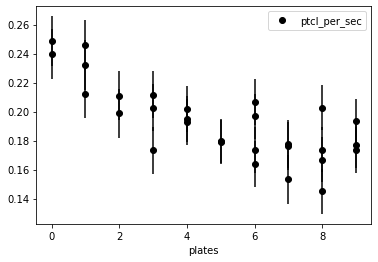

In [6]:
data.plot(x='plates', y='ptcl_per_sec', fmt='ok', yerr=(eps_err * data['ptcl_per_sec']))

In [7]:
data['avg_ptcls'] = data.groupby('plates')['ptcl_per_sec'].transform('mean')

<AxesSubplot:xlabel='plates'>

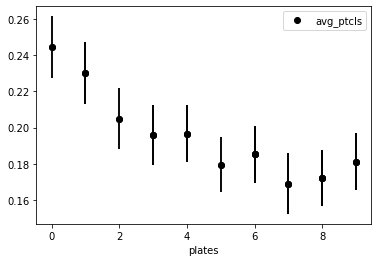

In [8]:
data.plot(x='plates', y='avg_ptcls', fmt='ok', yerr=(eps_err * data['ptcl_per_sec']))

In [9]:
data_s = data.sort_values(by=['plates']).drop_duplicates(subset=['plates']).loc[:, ['width', 'avg_ptcls']]

2
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.00215911596119929		+/- 0.00057265 (26.52%)
    k0 =  0.209334766313933		+/- 0.0068239 (3.26%)



3
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.00185185185185187		+/- 0.0007305 (39.45%)
    k0 =  0.205033068783069		+/- 0.0092401 (4.507%)



4
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.00165145502645503		+/- 0.00102 (61.77%)
    k0 =  0.202093915343915		+/- 0.013711 (6.784%)



5
    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k1 = -0.000497685185185195		+/- 0.00118 (237.1%)
    k0 =  0.184402777777778		+/- 0.016854 (9.14%)





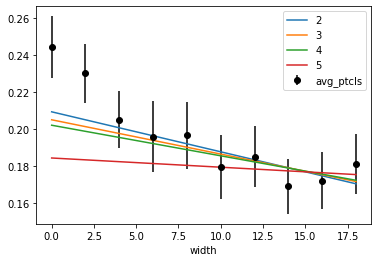

In [10]:
fig, ax = plt.subplots()
sigma_gnrl = (eps_err[data_s.index] * data_s['avg_ptcls']).to_numpy()
data_s.plot(x='width', y='avg_ptcls', ax=ax, fmt='ok',
            yerr=sigma_gnrl)
for i in range(2, 6):
    popt_i, pcov_i = np.polyfit(data_s['width'][i:], data_s['avg_ptcls'][i:], deg=1, cov=True)
    ax.plot(data_s['width'], np.polyval(popt_i, data_s['width']), label=f'{i}')
    print(i, end='')
    print_errors(popt_i, pcov_i)
    print('\n')
ax.legend()

In [11]:
def approx_func(width, N0, lmbd, C):
    return N0 * np.exp(-width / lmbd) + C

In [12]:
popt_gnrl, pcov_gnrl = curve_fit(approx_func, data_s['width'], data_s['avg_ptcls'])
gnrl_apx_std = np.absolute(data_s['avg_ptcls'] - approx_func(data['width'], *popt_gnrl)).std()
print_errors(popt_gnrl, pcov_gnrl)


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k2 = 0.0761255986819476		+/- 0.0071312 (9.368%)
    k1 =   5.92592412887493		+/- 1.5496 (26.15%)
    k0 =   0.17025033233172		+/- 0.0064447 (3.785%)



Text(0.5, 1.0, 'Particles per second')

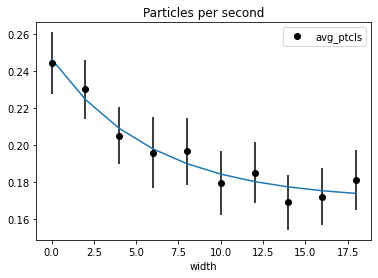

In [13]:
data_s.plot(x='width', y='avg_ptcls', fmt='ok', yerr=sigma_gnrl)
plt.plot(data_s['width'], approx_func(data_s['width'], *popt_gnrl))
plt.title('Particles per second')

In [14]:
n = 2
popt_line = np.polyfit(data_s['width'][n:], data_s['avg_ptcls'][n:], deg=1)
line_apx_std = np.absolute(data_s['avg_ptcls'][n:] - approx_func(data['width'][n:], *popt_gnrl)).std()
data_s['soft'] = data_s['avg_ptcls'] - np.polyval(popt_line, data_s['width'])

sigma_soft = np.sqrt(line_apx_std ** 2 + sigma_gnrl ** 2)

In [15]:
popt_soft, pcov_soft = curve_fit(approx_func, data_s['width'], data_s['soft'], sigma=sigma_soft)
soft_apx_std = np.absolute(data_s['soft'] - approx_func(data['width'], *popt_soft)).std()
print_errors(popt_soft, pcov_soft)


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k2 = 0.0394215570081367		+/- 0.0079495 (20.17%)
    k1 =   3.00675760691457		+/- 1.4026 (46.65%)
    k0 = -0.00214068296046881		+/- 0.0037507 (175.2%)



Text(0.5, 1.0, 'Soft component')

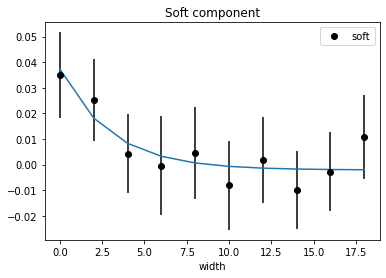

In [16]:
data_s.plot(x='width', y='soft', fmt='ok', yerr=sigma_soft)
plt.plot(data_s['width'], approx_func(data_s['width'], *popt_soft))
plt.title('Soft component')

In [17]:
data_s['hard'] = approx_func(data_s['width'], *popt_gnrl) - approx_func(data_s['width'], *popt_soft)
sigma_hard = np.sqrt(gnrl_apx_std ** 2 + soft_apx_std ** 2 + sigma_gnrl ** 2)

In [18]:
popt_hard, pcov_hard = curve_fit(approx_func, data_s['width'], data_s['hard'], sigma=sigma_hard)
hard_apx_std = np.absolute(data_s['hard'] - approx_func(data['width'], *popt_hard)).std()
print_errors(popt_hard, pcov_hard)


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k2 = 0.0543174694353998		+/- 0.0079831 (14.7%)
    k1 =   16.3318840194163		+/- 4.2889 (26.26%)
    k0 =  0.156718411778867		+/- 0.0085647 (5.465%)



Text(0.5, 1.0, 'Hard component')

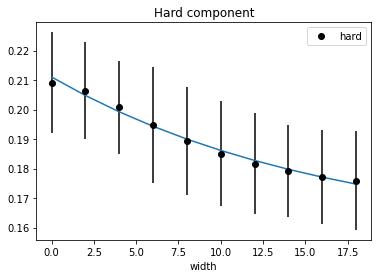

In [19]:
data_s.plot(x='width', y='hard', fmt='ok', yerr=sigma_hard)
plt.plot(data_s['width'], approx_func(data_s['width'], *popt_hard))
plt.title('Hard component')

# Итоговые графики

In [20]:
x = np.linspace(data_s['width'].min(), data_s['width'].max(), 200)

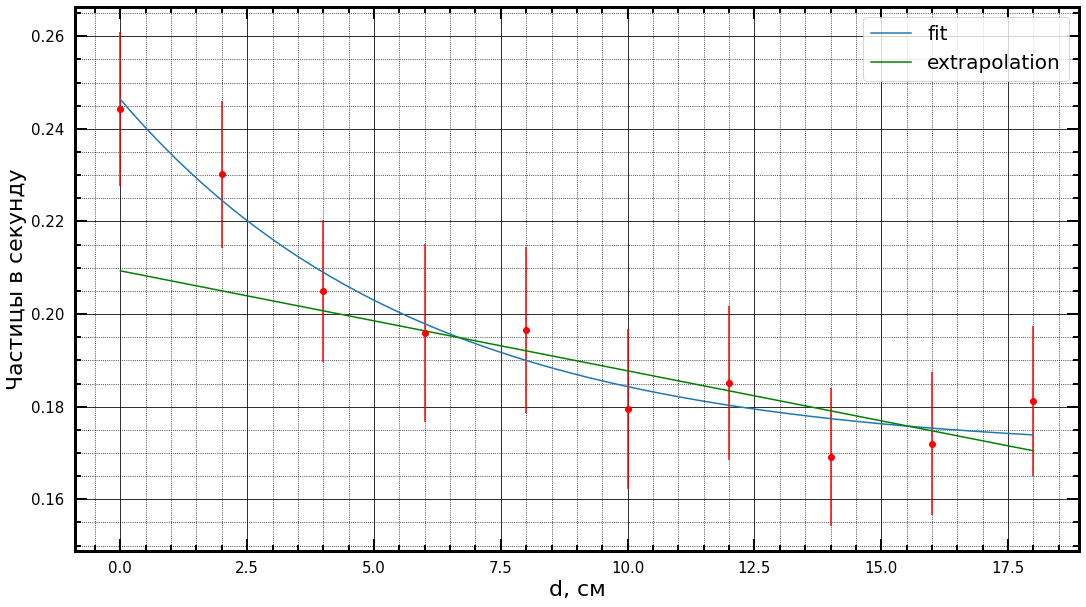

In [21]:
fig1, ax1 = create_plot(18, 10)
ax1.errorbar(data_s['width'], data_s['avg_ptcls'], fmt='or', yerr=sigma_gnrl)
ax1.plot(x, approx_func(x, *popt_gnrl), label='fit')
ax1.plot(x, np.polyval(popt_line, x), color='green', label='extrapolation')

ax1.set_xlabel('d, см', fontsize=22)
ax1.set_ylabel('Частицы в секунду', fontsize=22)
ax1.legend(fontsize=20)

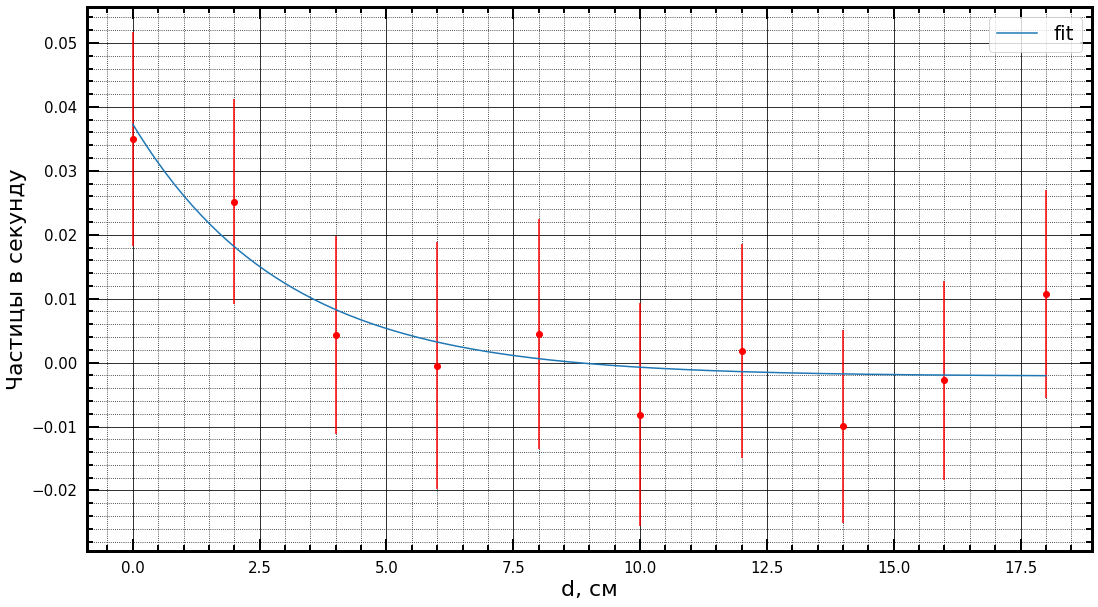

In [22]:
fig2, ax2 = create_plot(18, 10)
ax2.errorbar(data_s['width'], data_s['soft'], fmt='or', yerr=sigma_soft)
ax2.plot(x, approx_func(x, *popt_soft), label='fit')

ax2.set_xlabel('d, см', fontsize=22)
ax2.set_ylabel('Частицы в секунду', fontsize=22)
ax2.legend(fontsize=20)

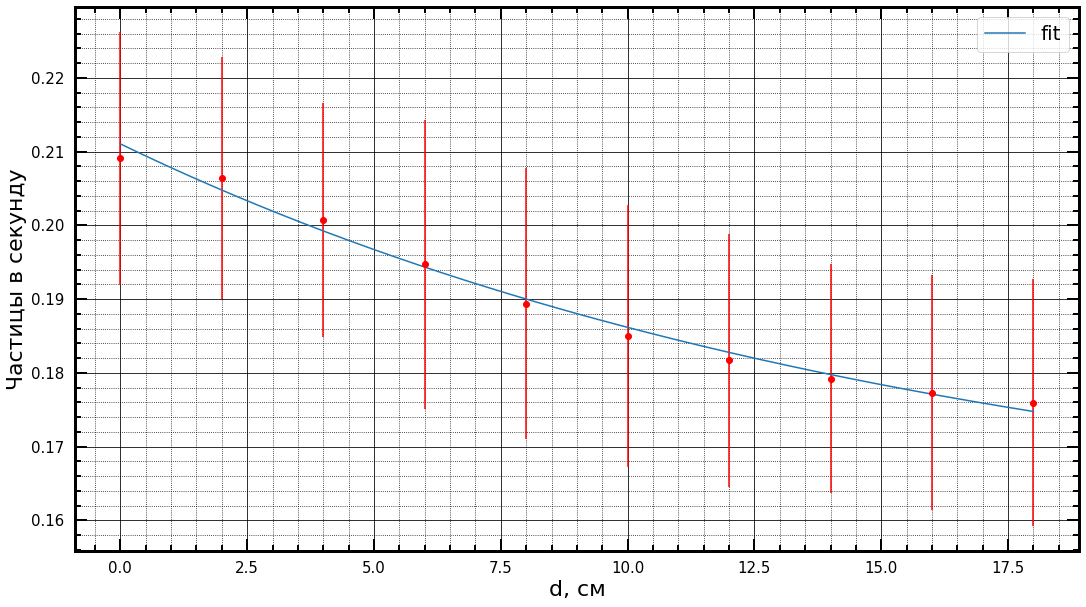

In [23]:
fig3, ax3 = create_plot(18, 10)
ax3.errorbar(data_s['width'], data_s['hard'], fmt='or', yerr=sigma_hard)
ax3.plot(x, approx_func(x, *popt_hard), label='fit')

ax3.set_xlabel('d, см', fontsize=22)
ax3.set_ylabel('Частицы в секунду', fontsize=22)
ax3.legend(fontsize=20)

In [24]:
for i, fig in enumerate([fig1, fig2, fig3]):
    fig.tight_layout()
    fig.savefig(f'graphs/plot_{i+1}.pdf')

In [35]:
rho = 11.34
coefs = np.array([x[1] for x in [popt_gnrl, popt_soft, popt_hard]])
lmbds = coefs * rho
lmd_err = np.array([np.sqrt(np.diag(x))[1] for x in [pcov_gnrl, pcov_soft, pcov_hard]])/coefs * lmbds

In [36]:
lmbds, lmd_err

(array([ 67.19997962,  34.09663126, 185.20356478]),
 array([17.57210183, 15.9050594 , 48.63609327]))

In [39]:
S = 8.4 * 30
l = 39
omega = 4 * S / l**2
omega_eps = np.sqrt((0.05/8.4)**2 + (0.05/30)**2 + (2/l)**2)
omega, omega_eps * omega

(0.6627218934911243, 0.03423173428779711)

In [51]:
I_hard = (data_s['avg_ptcls'] - data_s['soft']).iloc[0] / (S * omega)
I_soft = data_s['soft'].iloc[0] / (S * omega)

I_hard_sigma = (sigma_hard/data_s['hard']).iloc[0] * I_hard
I_soft_sigma = (sigma_soft/data_s['soft']).iloc[0] * I_soft

In [52]:
I_hard, I_hard_sigma

(0.0012534571820810188, 0.00010264048097379453)

In [53]:
I_soft, I_soft_sigma

(0.00020939850417496498, 0.00010033234525437847)